## An example of custom local SHC model evaluation

In [1]:
# load data from VirES server

from viresclient import SwarmRequest

request = SwarmRequest("https://staging.viresdisc.vires.services/openows")
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=['B_NEC'],
    auxiliaries=['QDLat'],
    sampling_step="PT1S" 
)
data = request.get_between(
    start_time="2014-01-01T00:00:00Z",
    end_time="2014-01-02T00:00:00Z"
).as_xarray()

[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Can't download new leap second table
Can't find leap second table.  Using one built into code.
Last leap second in built in table is on Jan 01 2017. 


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (5.621MB)


In [2]:
# extrat times, coordinates and other data

from numpy import asarray, datetime64, stack

NS2DAYS = 1.0/(24*60*60*1e9) # nano seconds to days scale factor

# time as MJD2000
times = (
    asarray(data["Timestamp"], dtype="M8[ns]") - datetime64('2000')
).astype('int64') * NS2DAYS

# spherical coordinates
coords = stack((
    asarray(data["Latitude"]), # latitude in deg
    asarray(data["Longitude"]), # latitude in deg
    asarray(data["Radius"])*1e-3, # radius in km
), axis=1)

# measurements
b_nec_measured = asarray(data["B_NEC"])

# quasi-dipole latitudes
qdlats = asarray(data["QDLat"])

In [3]:
# load model and evaluate the model

from eoxmagmod import load_model_shc
from eoxmagmod.data import CHAOS6_CORE_LATEST as CUSTOM_SHC_FILE

custom_model = load_model_shc(CUSTOM_SHC_FILE)

b_nec_model = custom_model.eval(times, coords, scale=[1, 1, -1]) # note the reversed radial component

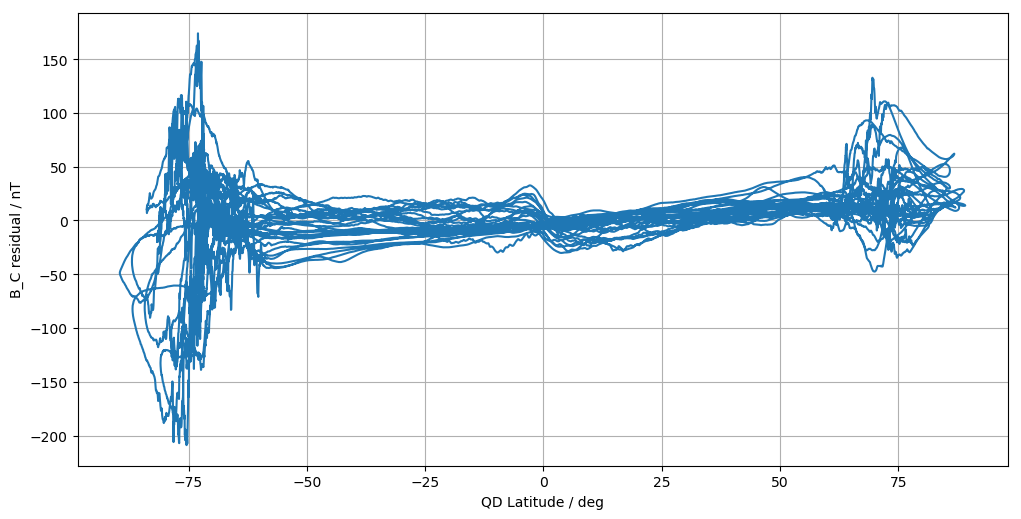

In [5]:
# display residuals

from matplotlib.pyplot import figure, subplot, show

b_nec_res = b_nec_measured - b_nec_model

fig = figure(figsize=(12, 6), dpi=100)
ax = subplot(111)
ax.plot(qdlats, b_nec_res[..., 2])
ax.grid()
ax.set_xlabel('QD Latitude / deg')
ax.set_ylabel('B_C residual / nT')

show()